# Creating Distance-based features

This notebook is used to test code that will create the distance-based features.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import math

In [4]:
# Custome functions to help create features
from src.utils import haversine, calc_xydist
from src.quadtree import Point, Rect, QuadTree

---

## Calculate SW and NE corner points to denote bounding area 

Using the training data, we can calculate the min and max coordinates. We then extend these slightly and use them to define the boundary area for Singapore.

In [5]:
# Load the training data
train_path = 'data/train.csv'
train = pd.read_csv(train_path)

In [6]:
# Since the coordinates are geodetic, their units are in degrees. The coordinates will be extended 
# by 0.5 degrees which approximately equates to about 5 km along the Earths surface.
deg_offset = 0.05 

In [7]:
ref_min_lat = train['latitude'].min() - deg_offset
ref_min_long = train['longitude'].min() - deg_offset
ref_max_lat = train['latitude'].max() + deg_offset
ref_max_long = train['longitude'].max() + deg_offset

print(f"Reference Origin (lat, long): {ref_min_lat}, {ref_min_long}")
print(f"Maximum Coord (lat, long): {ref_max_lat}, {ref_max_long}")

Reference Origin (lat, long): 1.2203795117581597, 103.63522841782499
Maximum Coord (lat, long): 1.5070712161383, 104.037804503483


The reference origin will be used to calculate the Cartesian coordinates of all entities in the data.

In [8]:
# 1st entry in data
train.iloc[0]
# manually validate coord in google maps

month                            2001-08
town                           pasir ris
flat_type                         4 room
block                                440
street_name            pasir ris drive 4
storey_range                    01 to 03
floor_area_sqm                       118
flat_model                       model a
eco_category               uncategorized
lease_commence_date                 1989
latitude                         1.36901
longitude                        103.959
elevation                              0
subzone                  pasir ris drive
planning_area                  pasir ris
region                       east region
resale_price                      209700
Name: 0, dtype: object

In [9]:
test_lat, test_long = train.iloc[0][['latitude','longitude']]

In [10]:
test_x, test_y = calc_xydist(test_long, test_lat, ref_min_long,ref_min_lat)
print(f"Distance to origin (x,y): {test_x},{test_y} km")

Distance to origin (x,y): 35.95775442315713,16.5267442089845 km


In [11]:
dist = haversine(test_long, test_lat, ref_min_long,ref_min_lat)
print(f"Euclid distance to origin: {dist} km")

Euclid distance to origin: 39.57487375074682 km


Above distance was successfully checked against visual inspection on Google Maps (the slight difference is due to the manual selection of points on the map).

<!-- ![Check distance](./images/check_xydist.png) -->

<img src="./images/check_xydist.png" alt="Drawing" style="width: 600px;"/>

## Quadtree data structure and radius search

Data from the various amenities will be stored in a Quadtree data tree. This is more efficient than storing the data in a list or dictionary. It allows for the searching of elements by distance in $O({log}_{2}n)$.

In this notebook, we test the quadtree code using MRT data.

In [12]:
width, height = calc_xydist(ref_max_long, ref_max_lat, ref_min_long,ref_min_lat)
width = math.ceil(width)
height = math.ceil(height)
print(f"Dimensions of Bounding area in km: {width}, {height}") # Bounding box size in km

Dimensions of Bounding area in km: 45, 32


In [13]:
mrt_data_path = 'data/auxiliary-data/sg-train-stations.csv'
mrt = pd.read_csv(mrt_data_path)

In [14]:
mrt.head()

,name,codes,lat,lng,opening_year,type
0,Eunos,EW7,1.319778,103.903252,1989.0,mrt
1,Chinese Garden,EW25,1.342352,103.732596,1988.0,mrt
2,Khatib,NS14,1.417383,103.832980,1988.0,mrt
3,Kranji,NS7,1.425177,103.762165,1996.0,mrt
4,Redhill,EW18,1.289562,103.816816,1988.0,mrt


In [15]:
# Create new columns that will store the coordinates and the composite name for the station
mrt['x'] = np.nan
mrt['y'] = np.nan
mrt['long_name'] = mrt['name'] + '_' + mrt['type']

mrt.head()

,name,codes,lat,lng,opening_year,type,x,y,long_name
0,Eunos,EW7,1.319778,103.903252,1989.0,mrt,NaN,NaN,Eunos_mrt
1,Chinese Garden,EW25,1.342352,103.732596,1988.0,mrt,NaN,NaN,Chinese Garden_mrt
2,Khatib,NS14,1.417383,103.832980,1988.0,mrt,NaN,NaN,Khatib_mrt
3,Kranji,NS7,1.425177,103.762165,1996.0,mrt,NaN,NaN,Kranji_mrt
4,Redhill,EW18,1.289562,103.816816,1988.0,mrt,NaN,NaN,Redhill_mrt


In [23]:
# Define a function to create the Quadtree data structure
def create_qtree(df, name_col = 'name'):
    
    print(f"Number of rows in data = {df.shape[0]}")
    
    qtree = QuadTree(domain, 3)
    points = []
    for index, row in df.iterrows():
        x, y = calc_xydist(row.lng, row.lat, ref_min_long,ref_min_lat)

        df.loc[index,'x'] = round(x, 2)
        df.loc[index,'y'] = round(y, 2)

        point = Point(x, y, name=row[name_col])

        points.append(point)
        qtree.insert(point)
        
    return qtree, points

In [25]:
# Define a function to visualize a quadtree object
def plot_qtree(points, qtree):
    
    print(f"Number of nodes in Quadtree = {len(qtree)}")
   
    DPI = 72
    fig = plt.figure(figsize=(700/DPI, 500/DPI), dpi=DPI)
    ax = plt.subplot()
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    qtree.draw(ax)
    ax.scatter([p.x for p in points], [p.y for p in points], s=4)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [24]:
# TODO: Better way?
domain = Rect(width/2, height/2, width, height)

mrt_qtree, mrt_points = create_qtree(mrt, name_col='long_name')
mrt.head()

Number of rows in data = 166


,name,codes,lat,lng,opening_year,type,x,y,long_name
0,Eunos,EW7,1.319778,103.903252,1989.0,mrt,29.79,11.05,Eunos_mrt
1,Chinese Garden,EW25,1.342352,103.732596,1988.0,mrt,10.82,13.56,Chinese Garden_mrt
2,Khatib,NS14,1.417383,103.832980,1988.0,mrt,21.98,21.91,Khatib_mrt
3,Kranji,NS7,1.425177,103.762165,1996.0,mrt,14.11,22.77,Kranji_mrt
4,Redhill,EW18,1.289562,103.816816,1988.0,mrt,20.19,7.69,Redhill_mrt


Number of nodes in Quadtree = 166


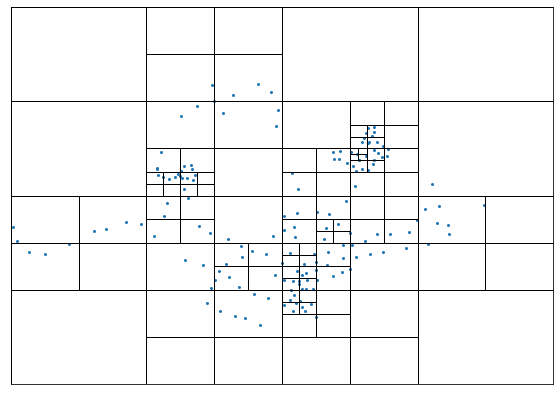

In [26]:
plot_qtree(mrt_points, mrt_qtree)

The plot above shows how the MRT data is stored in the Quadtree structure. Because MRT stations are found almost all over Singapore, you can almost trace the outline of the country from the data points.

To test the search functionality of the data structure, a location is selected from the train dataset. This is the 2nd row in the train data representing a property in Punggol.

A search radius of 2km is used. When first executed, the result showed 25 found stations which was suprising as MRT stations are usually quite a distance apart. Upon inspection, it showed that the results are actually LRT stations which are included in the datasets. These stations located in the North-East of Singapore are located much closer together that that of MRT stations. The plot shown below shows the found stations around the query location.

In [34]:
test_lat, test_long = train.iloc[1][['latitude','longitude']]

test_x, test_y = calc_xydist(test_long, test_lat, ref_min_long,ref_min_lat)
print(f"Distance to origin (x,y): {test_x},{test_y} km")

# Query point
centre = (test_x,test_y)
radius = 2 # in km 
found_points = []
mrt_qtree.query_radius(centre, radius, found_points)


print('Number of found points =', len(found_points))
for p in found_points:
    print(p.name)

Distance to origin (x,y): 30.209562601074747,19.862482837347994 km
Number of found points = 25
Oasis_other
Sam Kee_other
Farmway_other
Kadaloor_other
Coral Edge_other
Riviera_mrt
Cove_other
Kangkar_other
Meridian_other
Ranggung_other
Bakau_other
Rumbia_other
Cheng Lim_other
Compassvale_other
Sengkang_mrt
Sengkang_mrt
Punggol_mrt
Samudera_other
Nibong_other
Soo Teck_other
Damai_other
Punggol Point_other
Sumang_other
Punggol_mrt
Teck Lee_other


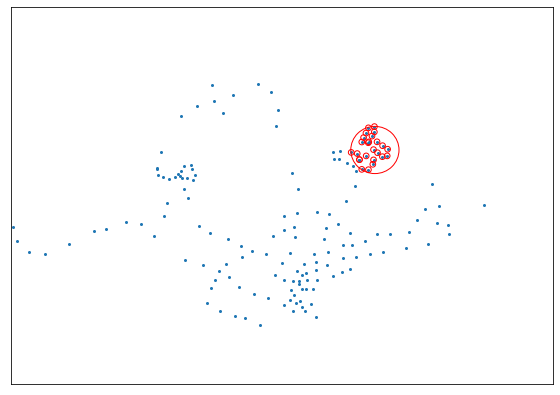

In [35]:
# Plot of the results of the search, modified from the plot function above

# Plot results
DPI = 72
fig = plt.figure(figsize=(700/DPI, 500/DPI), dpi=DPI)
ax = plt.subplot()

ax.set_xlim(0, width)
ax.set_ylim(0, height)

# Plot all points
ax.scatter([p.x for p in mrt_points], [p.y for p in mrt_points], s=4)
ax.set_xticks([])
ax.set_yticks([])

# Plot found points
ax.scatter([p.x for p in found_points], [p.y for p in found_points],
           facecolors='none', edgecolors='r', s=32)

# Draw search radius
circle = plt.Circle(centre, radius, ec='r', fill=False)
ax.add_patch(circle)
# Rect(*centre, 2*radius, 2*radius).draw(ax, c='r')

plt.show()

## Conclusion

This notebook has succefully shown how distance-based features can be added to the training data using auxiliary data of amenities. Using Cartesian coordinates allows for easy understanding of distances (in km instead of degrees) and the Quadtree data structure allows for the efficient search of elements in the area surrounding a query location. Once these results are found, features such as the count of amenities found within a search radius or distance to the nearest amenity can be calculated.

Take note that the actual implementation is the pipeline is modified to improve computation speed as these distance-based features will need to be calculated for each of the data points in the training data.